## Submission Summary

Basically, this notebook remains mostly the same. Only the data from inference part 1 changes.

* Submission 1 - Reshaped all images to a fixed size & no padding was done. Expectedly performed poor. But was faster in execution & did well for words of 3-4 characters.
* Submission 2 - Changed splitting criteria. `# Words = # Whitespaces > Mean whitespace`
* Submission 3 - Assumed `WordGap > 4 x CharacterGap`
* Submission 4 - Using code from [here](https://stackoverflow.com/questions/37771263/detect-text-area-in-an-image-using-python-and-opencv) to dettect words
* Final Submission - Trained on v3

## Importing Libraries

In [1]:
import ast
import os
from glob import glob
from itertools import chain
import random
from tqdm.notebook import tqdm

import cv2
import Levenshtein
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.layers import Activation, BatchNormalization, Bidirectional, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, Lambda, Layer, LSTM, MaxPooling2D, Reshape
from tensorflow.keras.models import Model, load_model

In [2]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
sns.set_style("darkgrid")

## Constants

In [3]:
SEED = 42
BATCH_SIZE = 16
max_length = 8

In [4]:
IMG_HEIGHT = 250
IMG_WIDTH = 600

## Utility Functions

In [5]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [6]:
seed_everything(SEED)

In [7]:
def plot_grid(dataset, h=5, w=5, title=""):
    f, ax = plt.subplots(h, w, figsize=(30, 30))
    for batch in dataset.shuffle(100).take(1):
        images = batch["image"]
        for i in range(h*w):
            img = (images[i] * 255).numpy().astype("uint8")
            ax[i // h, i % w].imshow(img[:, :, 0].T, cmap="gray")
            ax[i // h, i % w].axis("off")
    plt.tight_layout()
    plt.suptitle(title, fontsize="large", fontweight="extra bold")
    plt.show()

## Load Test Data

In [8]:
# !rm -r test_images
# !unzip -q ../input/handwritten-ocr-crnn-v1-inference/test_images.zip

In [9]:
test_df = pd.read_csv("../input/ocr-crnn-test-word-split-250-600/test_csv.csv")
test_images = glob("../input/ocr-crnn-test-word-split-250-600/test_images/test_images/*.png")

In [10]:
test_df.shape, len(test_images)

((994, 3), 5645)

In [11]:
test_df.head()

,Path,Splits,NumSplits
0,../input/arya-hw-lines/test/test/r07-568z-05.tif,"[0, 1, 2, 3, 4, 5]",6
1,../input/arya-hw-lines/test/test/r07-568z-07.tif,"[6, 7, 8, 9, 10, 11, 12]",7
2,../input/arya-hw-lines/test/test/r08-612z-05.tif,"[13, 14, 15, 16, 17, 18, 19]",7
3,../input/arya-hw-lines/test/test/p07-917z-05.tif,"[20, 21, 22, 23, 24]",5
4,../input/arya-hw-lines/test/test/r02-091z-01.tif,"[25, 26, 27, 28]",4


In [12]:
def plot_words(image_splits):
    num_cols = 4
    num_rows = len(image_splits)//num_cols
    num_rows = num_rows+1 if len(image_splits)%num_cols else num_rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    axes = axes.flatten()
    for idx, img in enumerate(image_splits):
        axes[idx].imshow(img)
        axes[idx].axis("off")
    plt.tight_layout()

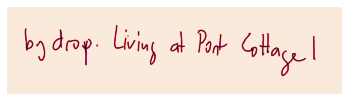

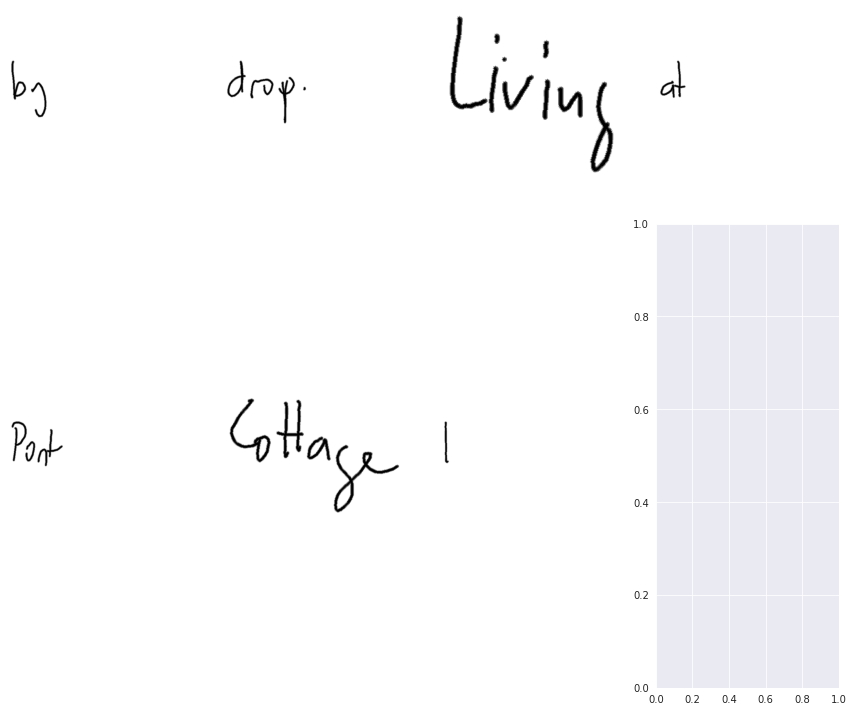

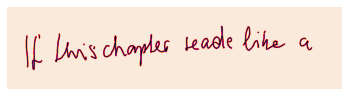

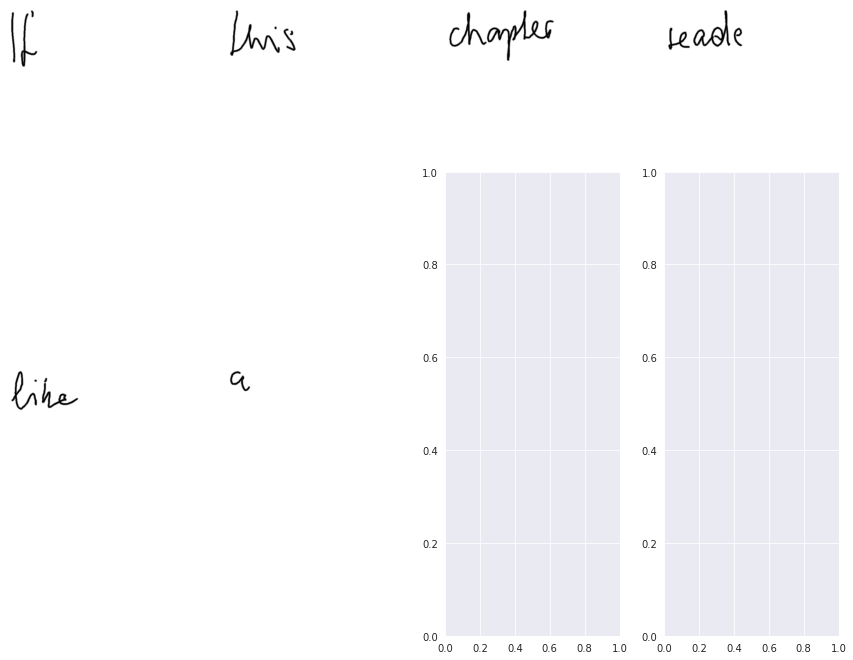

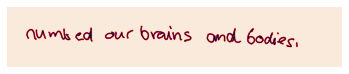

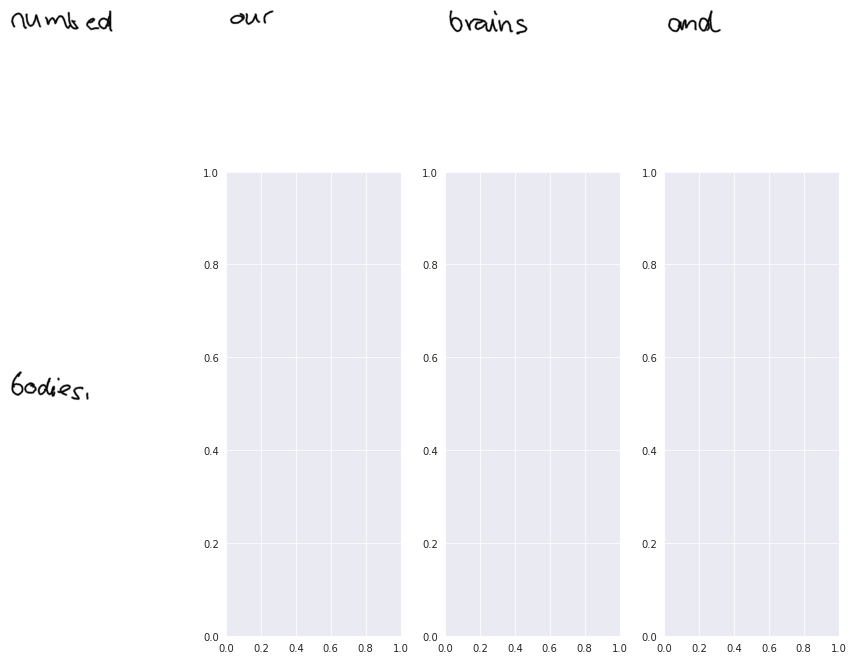

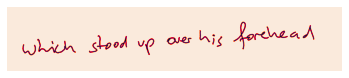

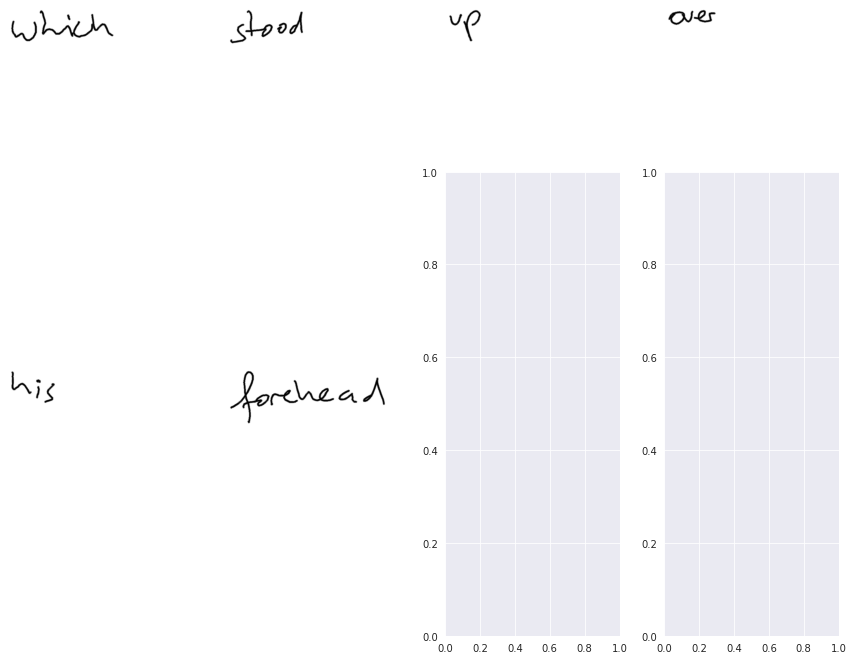

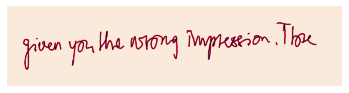

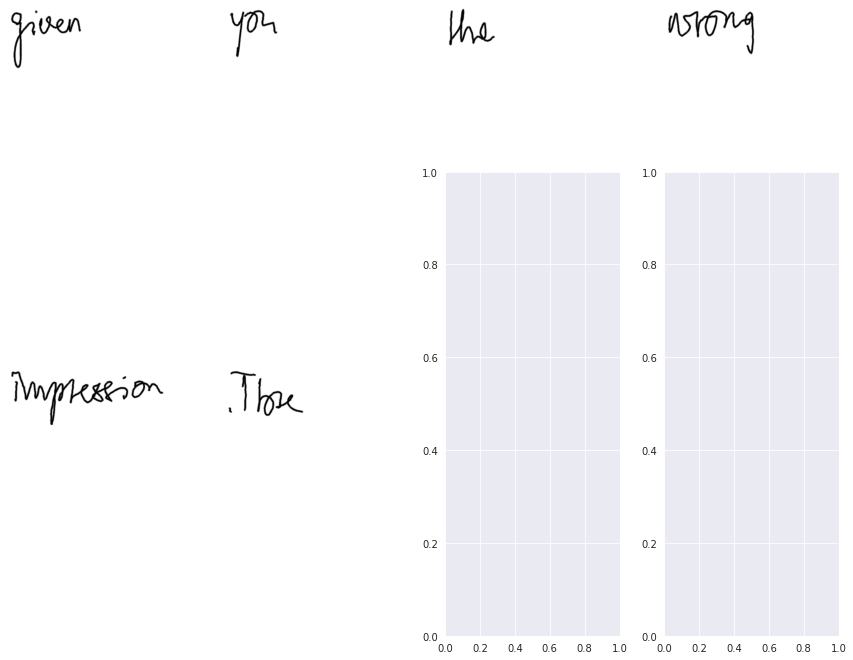

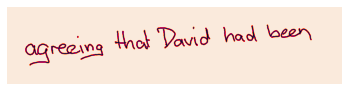

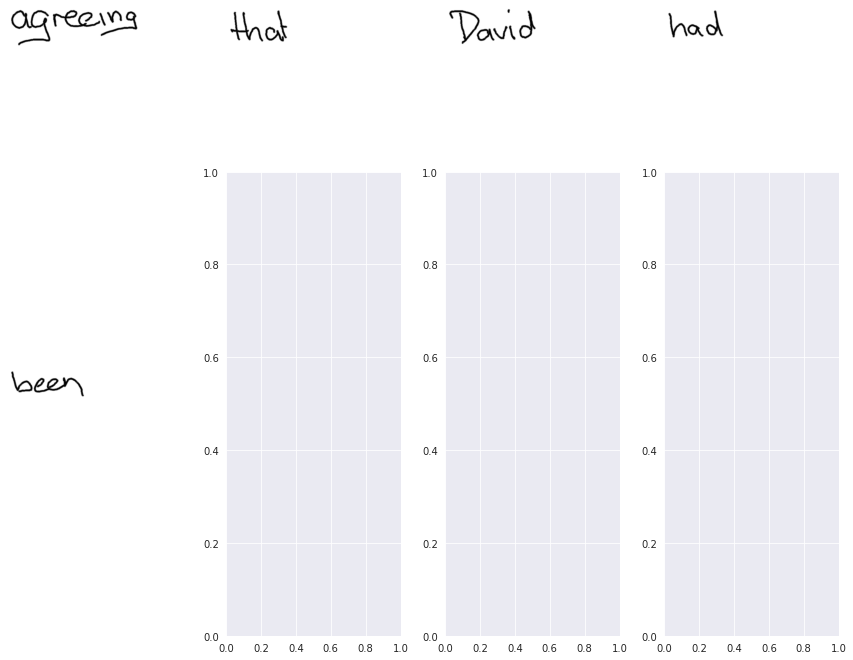

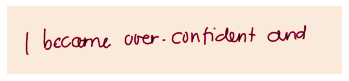

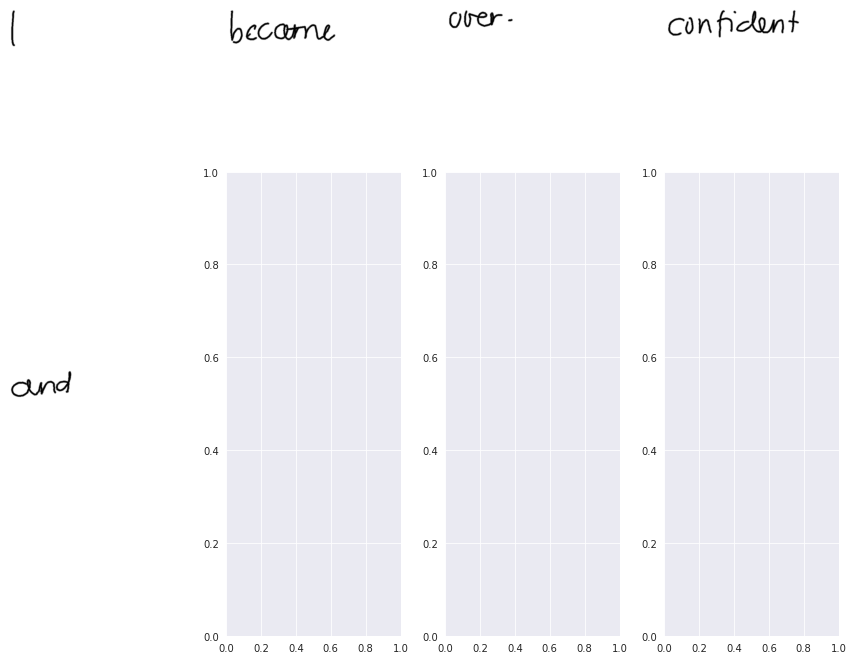

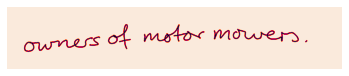

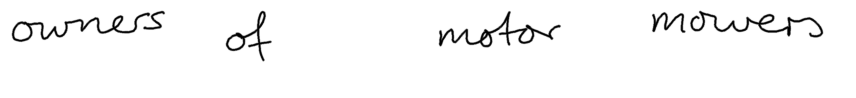

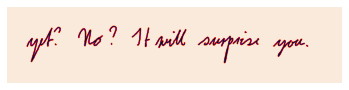

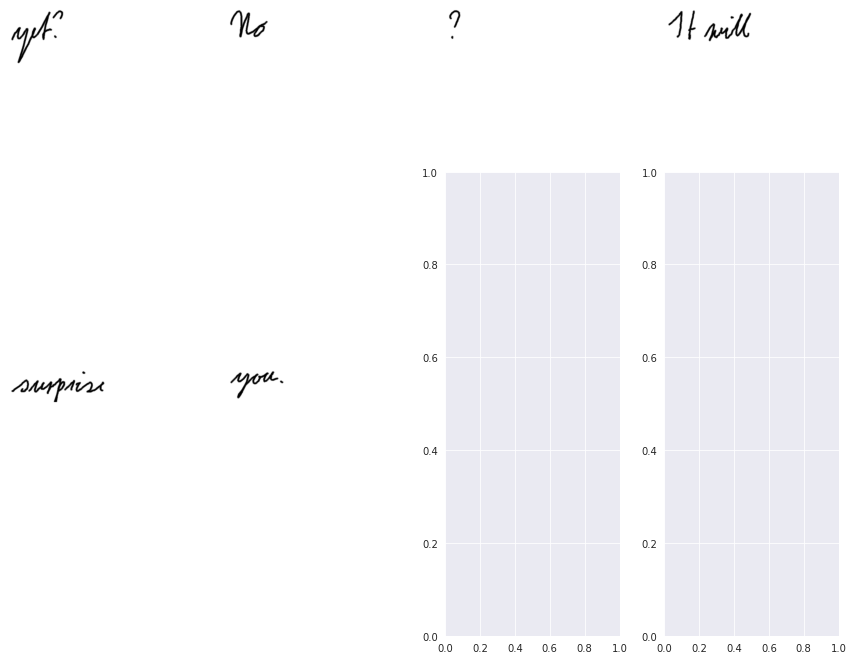

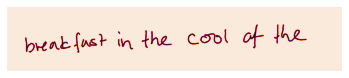

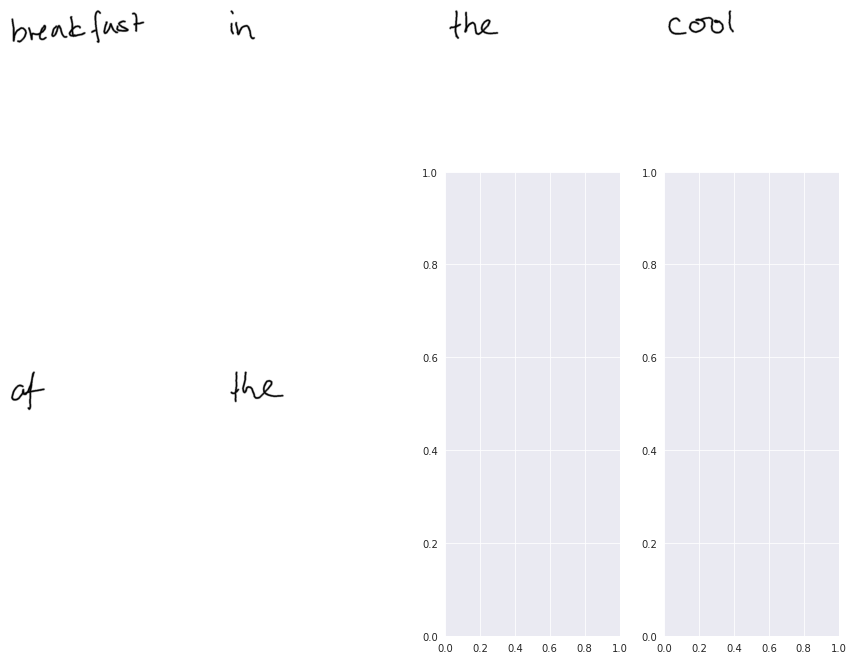

In [13]:
for idx in range(10, 20):
    image = cv2.imread(test_df["Path"].iloc[idx], 0)
    plt.figure()
    plt.imshow(image)
    plt.axis("off")
    image_splits = [cv2.imread(f"../input/ocr-crnn-test-word-split-250-600/test_images/test_images/{x}.png") for x in ast.literal_eval(test_df["Splits"].iloc[idx])]
    plot_words(image_splits)

## Image Processing Function

In [14]:
def encode_single_sample(img_path):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Return img
    return img

## Some Processing

In [15]:
characters = [']', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', 
              '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 
              'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
              'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 
              '[', '!']

In [16]:
# Mapping characters to integers
char_to_num = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), invert=True, mask_token=None
)

In [17]:
unk_token = "[UNK]"
mask_token = "]"

## CRNN

In [18]:
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [19]:
def build_crnn_model():
    # Inputs to the model
    input_img = Input(
        shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image", dtype="float32"
    )
    labels = Input(name="label", shape=(None,), dtype="float32")

    """
    Why is the need for 7 conv layers?
    """
    # First conv block
    x = Conv2D(16, (3, 3), activation="relu", padding="same", name="conv_1")(input_img)
    x = Conv2D(32, (3, 3), activation="relu", padding="same", name="conv_2")(x)
    x = Conv2D(64, (3, 3), activation="relu", padding="same", name="conv_3")(x)
    x = BatchNormalization(name="bn_1")(x)
    x = MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = Conv2D(64, (3, 3), activation="relu", padding="same", name="conv_4")(x)
    x = Conv2D(128, (3, 3), activation="relu", padding="same", name="conv_5")(x)
    x = BatchNormalization(name="bn_2")(x)
    x = MaxPooling2D((2, 2), name="pool2")(x)

    # Third conv block
    x = Conv2D(128, (3, 3), activation="relu", padding="same", name="conv_6")(x)
    x = Conv2D(128, (3, 3), activation="relu", padding="same", name="conv_7")(x)
    x = BatchNormalization(name="bn_3")(x)
    
    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing it to RNNs
    new_shape = ((IMG_WIDTH // 4), (IMG_HEIGHT // 4) * 128)
    x = Reshape(target_shape=new_shape, name="reshape")(x)
    x = Dense(64, activation="relu", name="dense1")(x)
    x = Dropout(0.2)(x)

    # RNNs
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2))(x)
    x = Bidirectional(LSTM(32, return_sequences=True, dropout=0.2))(x)

    # Output layer
    x = Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = tf.keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

## Load Model

In [20]:
model = tf.keras.models.load_model("../input/handwrittenocrcrnnv3/model_checkpoints/") 

In [21]:
prediction_model = tf.keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 600, 250, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 600, 250, 16)      160       
_________________________________________________________________
conv_2 (Conv2D)              (None, 600, 250, 32)      4640      
_________________________________________________________________
conv_3 (Conv2D)              (None, 600, 250, 64)      18496     
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 600, 250, 64)      256       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 300, 125, 64)      0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 300, 125, 64)      36928 

## Inference

In [22]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [23]:
test_df.head()

,Path,Splits,NumSplits
0,../input/arya-hw-lines/test/test/r07-568z-05.tif,"[0, 1, 2, 3, 4, 5]",6
1,../input/arya-hw-lines/test/test/r07-568z-07.tif,"[6, 7, 8, 9, 10, 11, 12]",7
2,../input/arya-hw-lines/test/test/r08-612z-05.tif,"[13, 14, 15, 16, 17, 18, 19]",7
3,../input/arya-hw-lines/test/test/p07-917z-05.tif,"[20, 21, 22, 23, 24]",5
4,../input/arya-hw-lines/test/test/r02-091z-01.tif,"[25, 26, 27, 28]",4


In [24]:
def get_all_preds(test_df):
    """
    Utility function that returns both model prediction & actual labels
    """
    labels = []
    for idx, row in tqdm(test_df.iterrows()):
        row_pred = []
        image_splits = [f"../input/ocr-crnn-test-word-split-250-600/test_images/test_images/{x}.png" for x in ast.literal_eval(row["Splits"])]
        for img_split in image_splits:
            processed_split = np.expand_dims(encode_single_sample(img_split), axis=0)
            split_pred = prediction_model.predict(processed_split)
            split_pred = decode_batch_predictions(split_pred)[0]
            # handling UNK & MASK token
            split_pred = split_pred.replace(unk_token, '').replace(mask_token, '')
            row_pred.append(split_pred)
        labels.append(" ".join(row_pred))
    return labels

In [25]:
predictions = get_all_preds(test_df)

0it [00:00, ?it/s]

In [26]:
submission_df = pd.DataFrame.from_dict({"imageName": test_df["Path"].apply(lambda x: x.split("/")[-1]), 
                                        "prediction": predictions})

In [27]:
submission_df.head()

,imageName,prediction
0,r07-568z-05.tif,T H M SSAY ABOUT HAIM
1,r07-568z-07.tif,AT HEASTRTO TNOU HE WAS P.C I
2,r08-612z-05.tif,T EMAINED THUS FOR A WHOLE SUMMMMER
3,p07-917z-05.tif,IDEA IIMU WERE AA WEAHTHY
4,r02-091z-01.tif,THE 1RSIN THREIV IITO


## Random Plots

### Word Level

In [28]:
def plot_grid_word_level(test_images, h=4, w=4, title=""):
    f, ax = plt.subplots(h, w, figsize=(30, 30))
    images = np.random.choice(test_images, size=h*w)
    for i in range(h*w):
        img = cv2.imread(images[i])
        # make prediction
        processed_split = np.expand_dims(encode_single_sample(images[i]), axis=0)
        label = prediction_model.predict(processed_split)
        label = decode_batch_predictions(label)[0]
        label = label.replace(unk_token, '').replace(mask_token, '')
        ax[i // h, i % w].imshow(img)
        ax[i // h, i % w].axis("off")
        ax[i // h, i % w].set_title(label, fontdict={"fontsize": 20})
    plt.tight_layout()
    plt.suptitle(title, fontsize="large", fontweight="extra bold")
    plt.show()

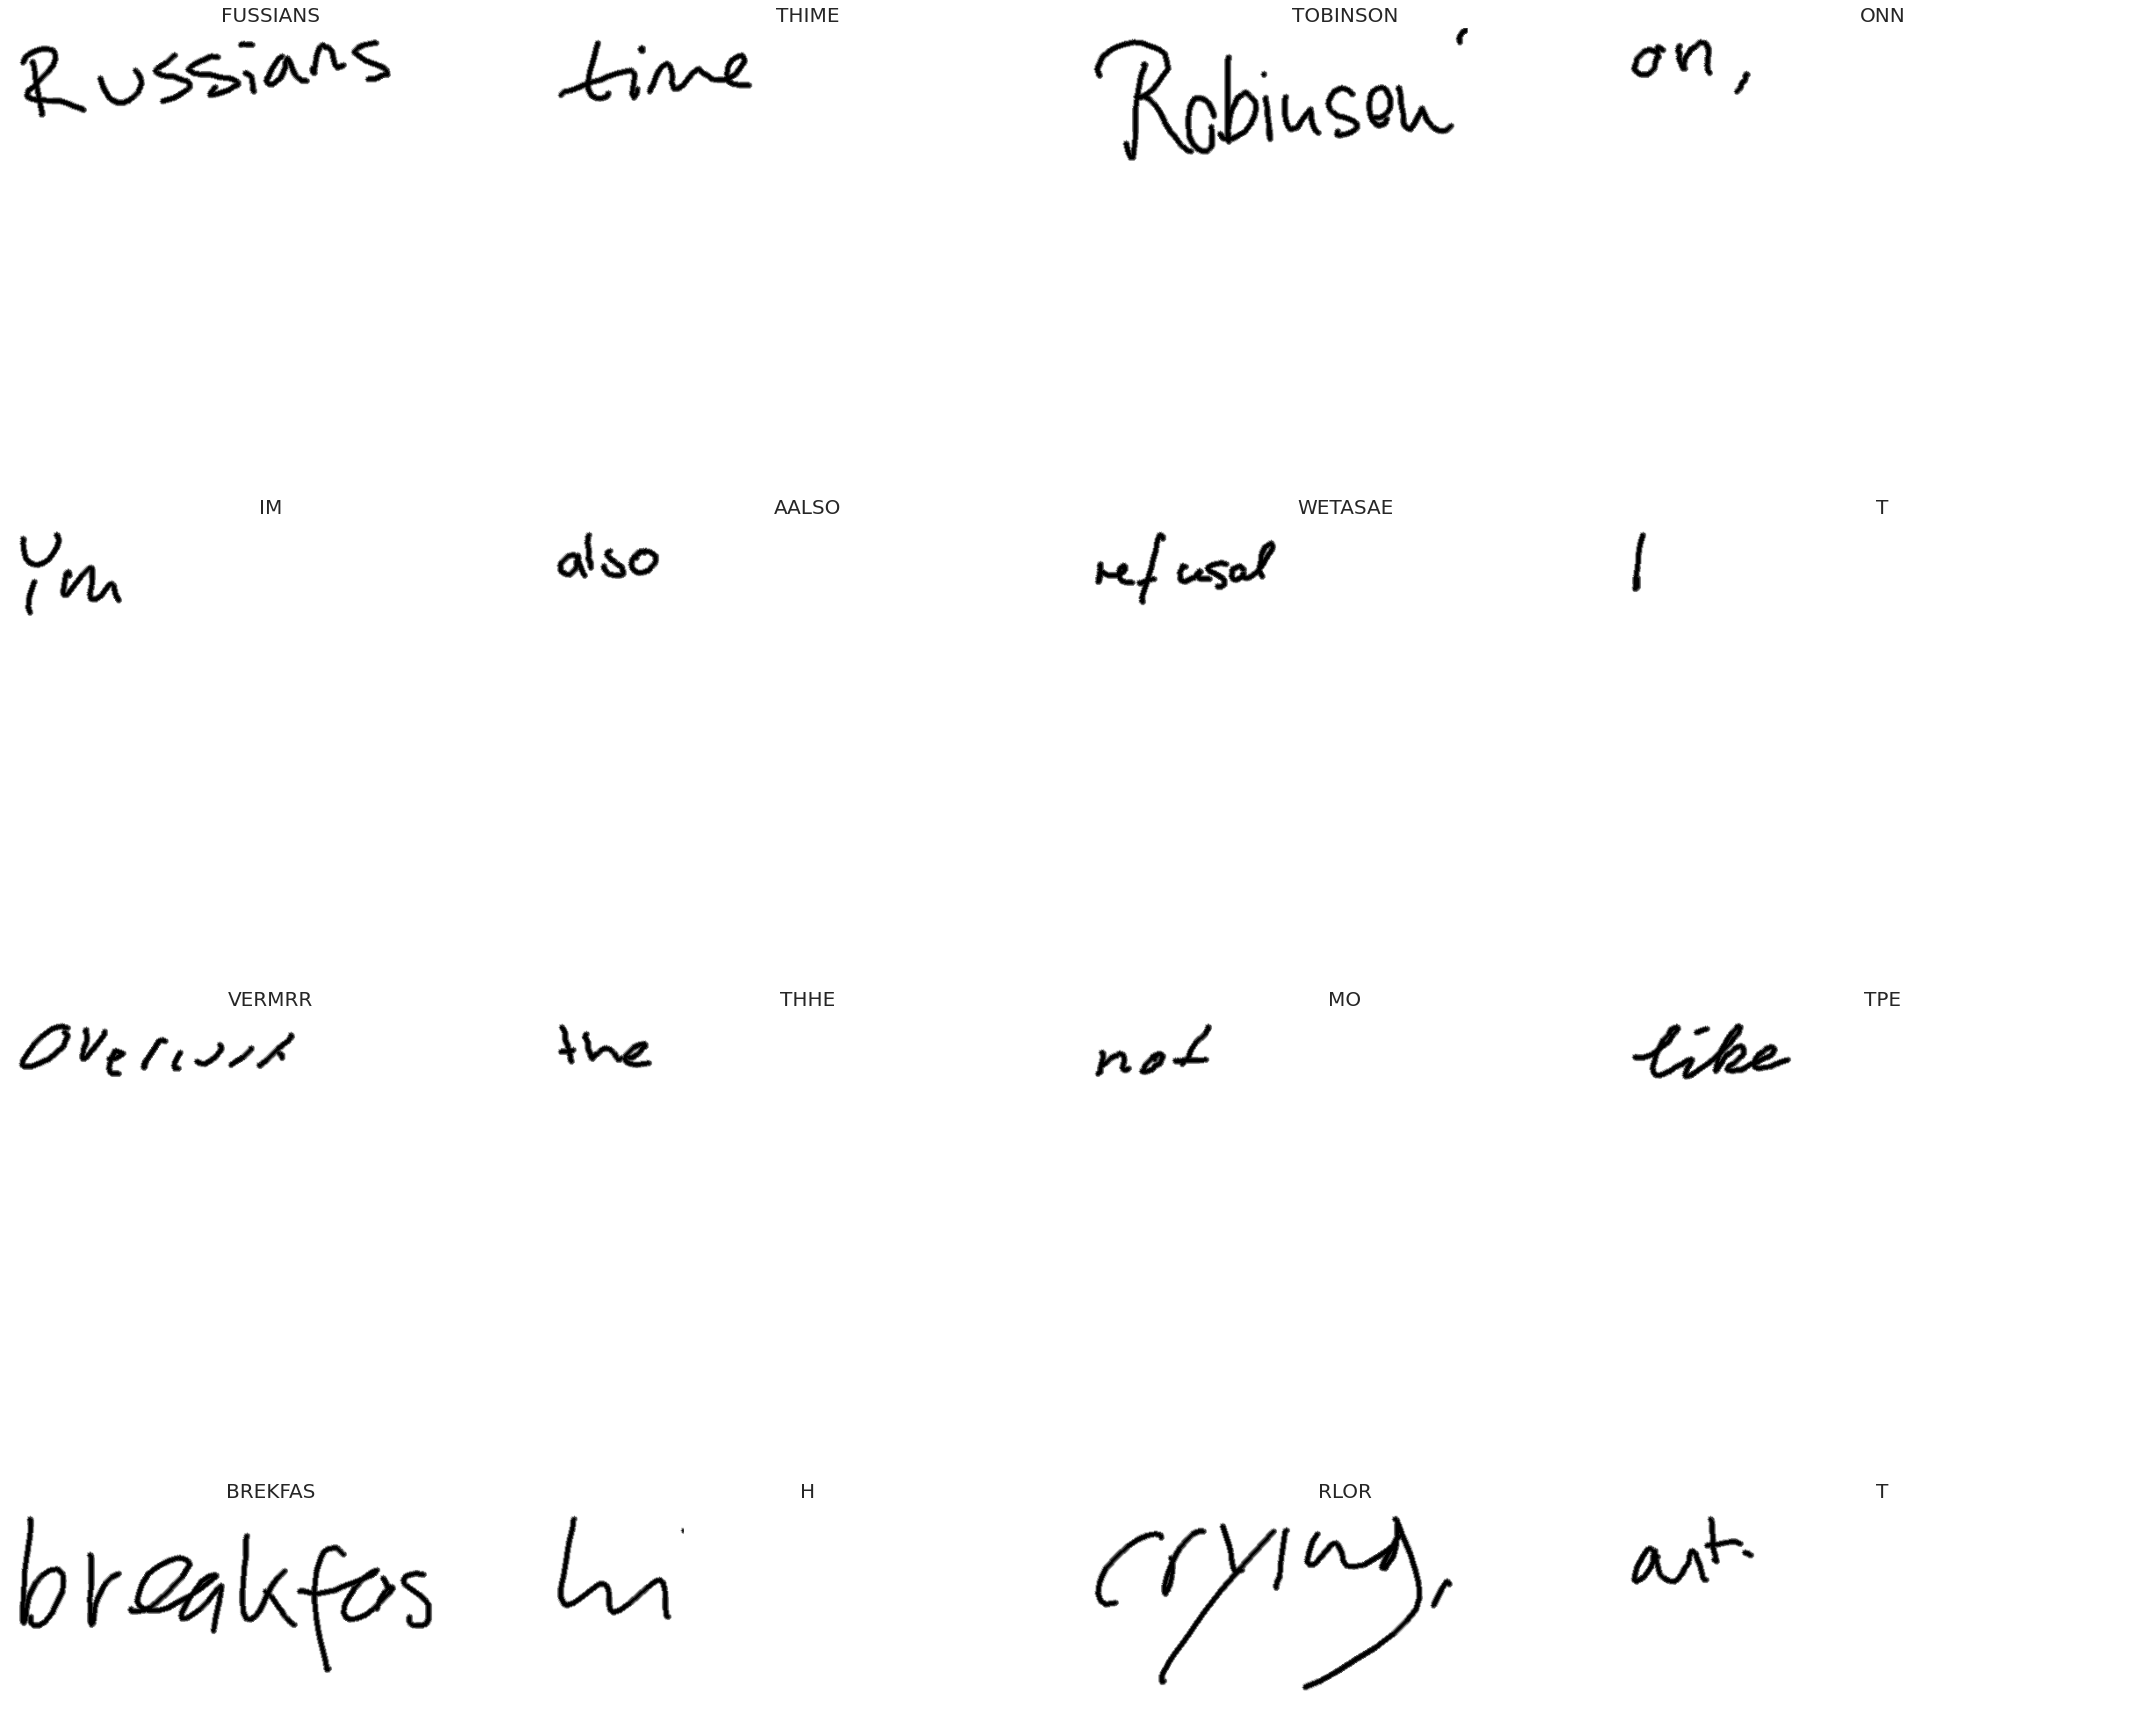

In [29]:
plot_grid_word_level(test_images)

### Sentence Level

In [30]:
def plot_grid(df, h=4, w=4, title=""):
    f, ax = plt.subplots(h, w, figsize=(30, 30))
    df = df.sample(h*w)
    images = df["imageName"].apply(lambda x: f"../input/arya-hw-lines/test/test/{x}").tolist()
    labels = df["prediction"].tolist()
    for i in range(h*w):
        img = cv2.imread(images[i])
        label = labels[i]
        ax[i // h, i % w].imshow(img)
        ax[i // h, i % w].axis("off")
        ax[i // h, i % w].set_title(label, fontdict={"fontsize": 20})
    plt.tight_layout()
    plt.suptitle(title, fontsize="large", fontweight="extra bold")
    plt.show()

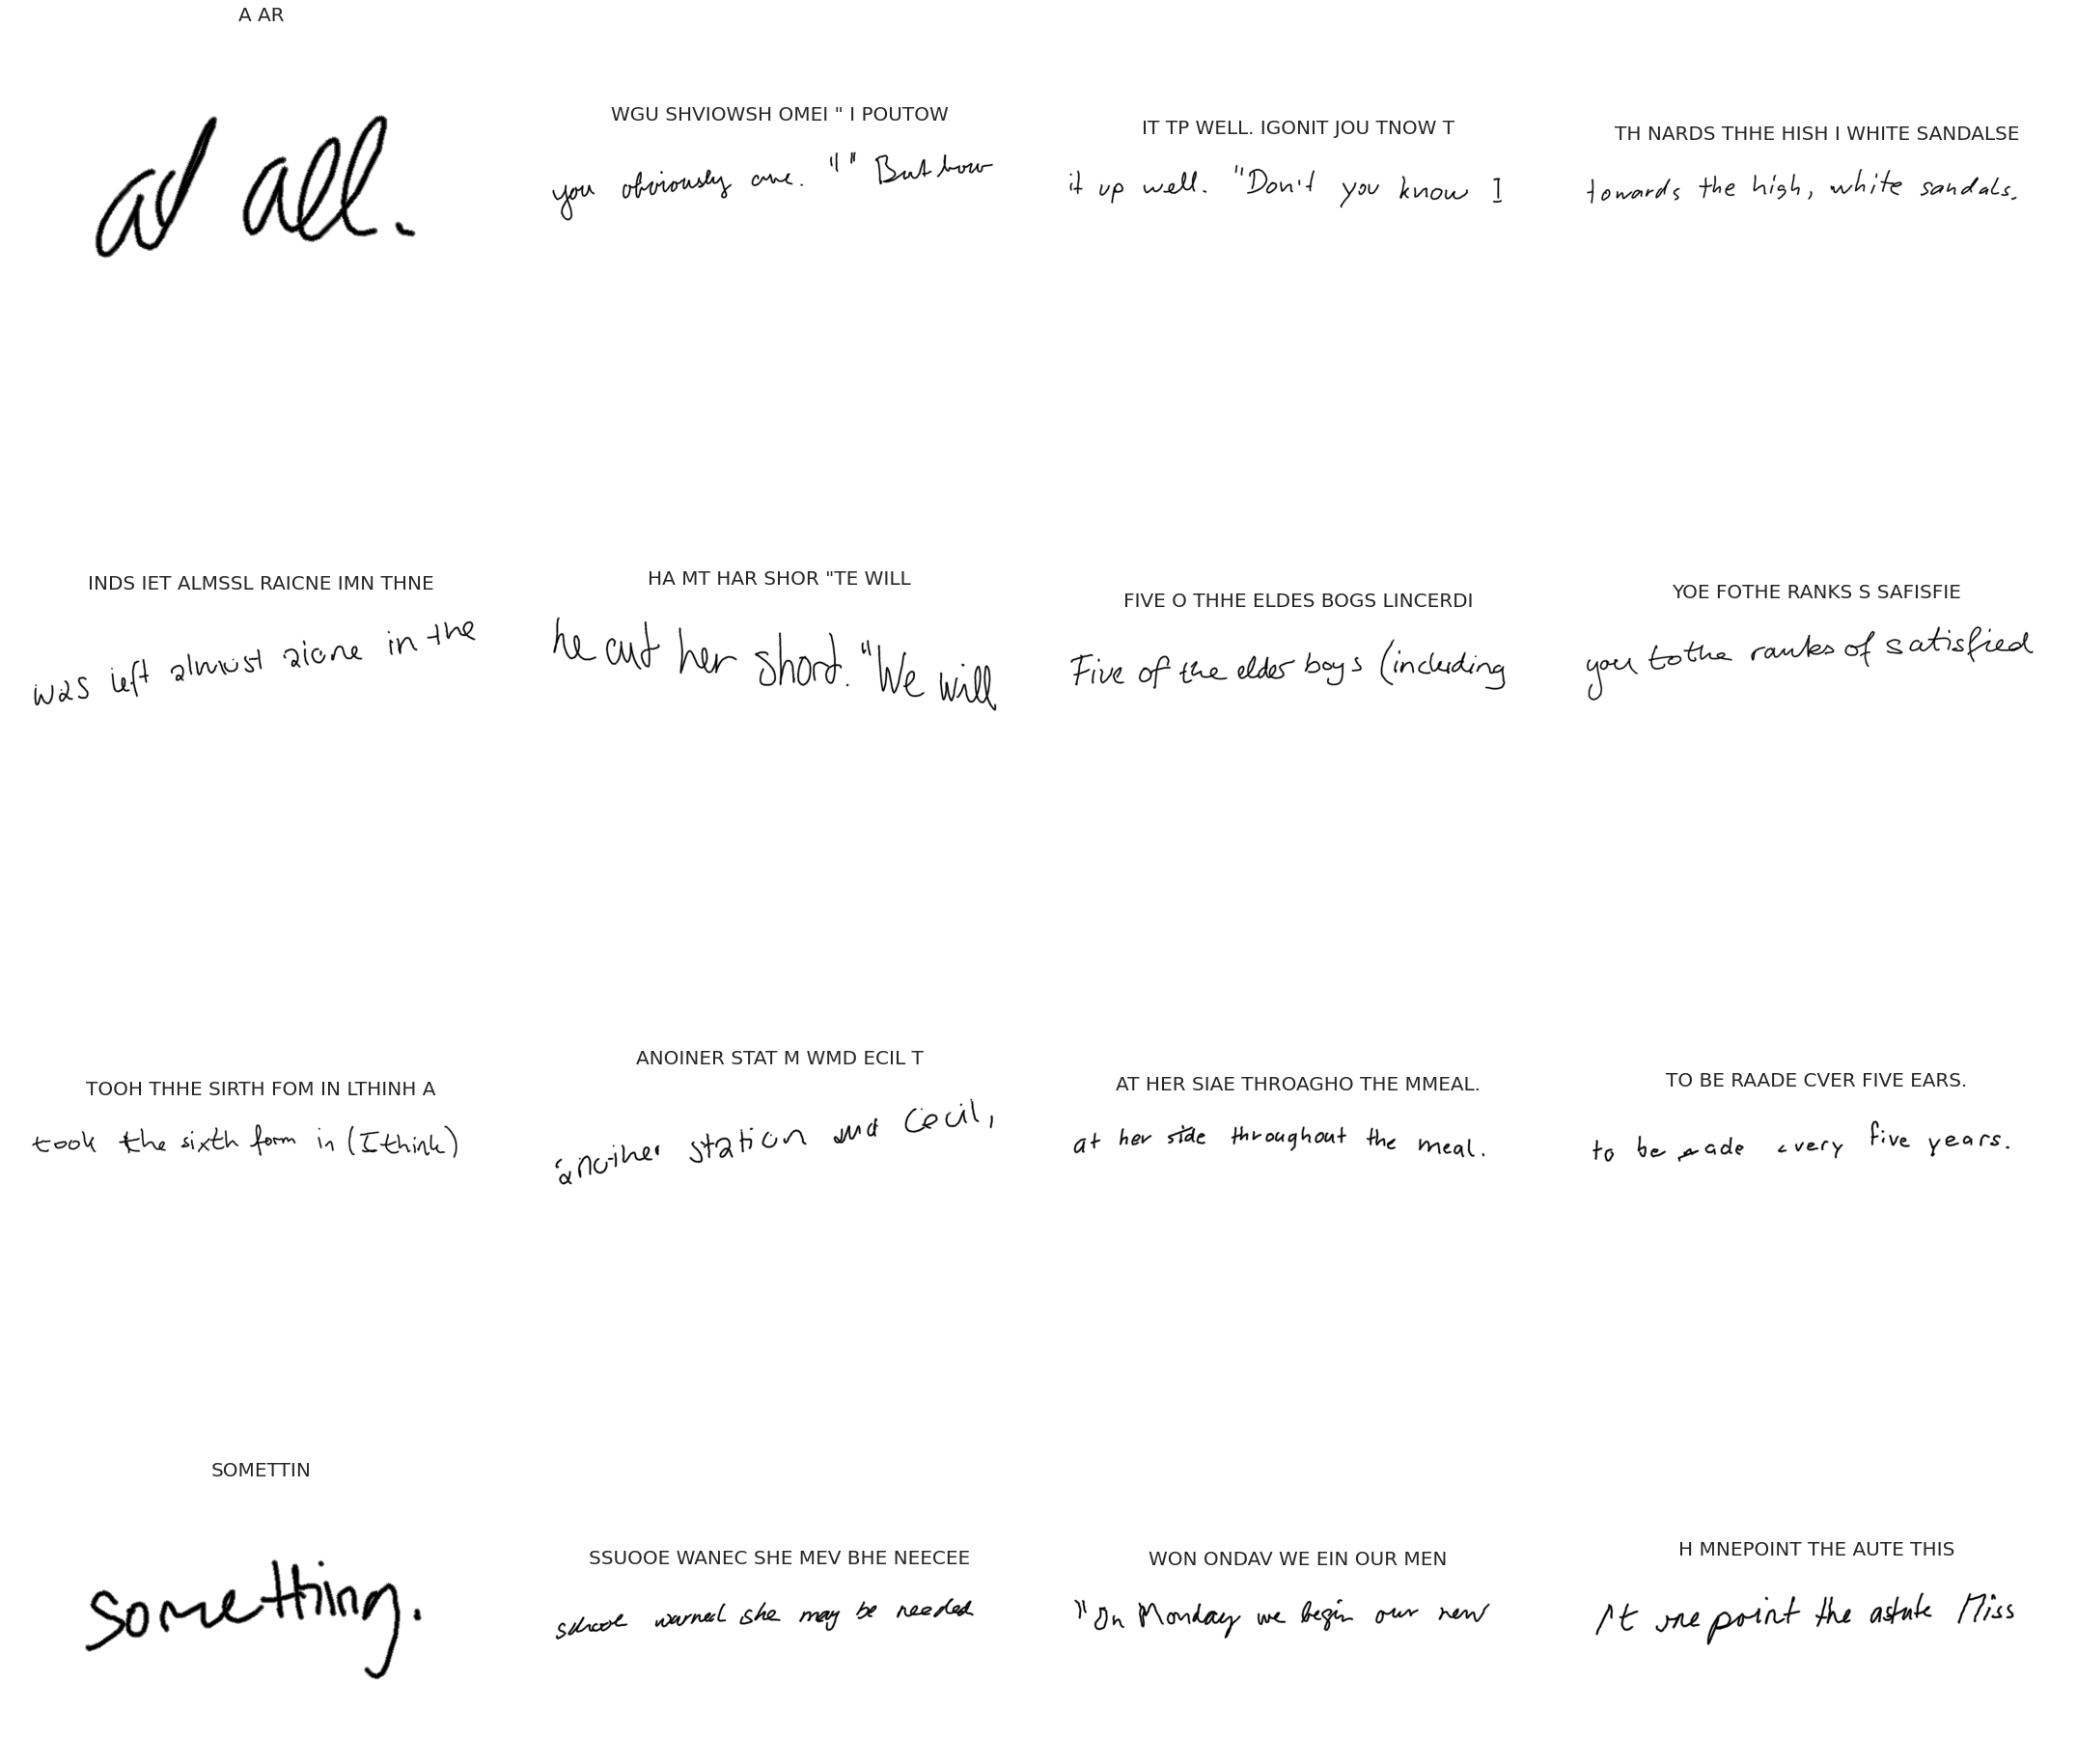

In [31]:
plot_grid(submission_df)

In [32]:
submission_df.to_csv("submission.csv", index=False)

In [33]:
!rm -rf test_images